### 0. Imports

In [1]:
import pandas as pd
from datetime import datetime

import statsmodels
import pmdarima

from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error

### 1. Load and Prepare Data

In [2]:
full_demand = pd.read_csv('../data/full_pge_demand.csv')

In [3]:
# convert datetime string to period object
full_demand['utc'] = [pd.Period(period, freq='H') for period in full_demand['utc']]

# create y series with period index
y = full_demand.set_index('utc')['demand_MWh']

In [20]:
y

utc
2015-07-22 08:00    1936.0
2015-07-22 09:00    1856.0
2015-07-22 10:00    1784.0
2015-07-22 11:00    1766.0
2015-07-22 12:00    1801.0
                     ...  
2022-10-10 13:00    1991.0
2022-10-10 14:00    2227.0
2022-10-10 15:00    2391.0
2022-10-10 16:00    2414.0
2022-10-10 17:00    2414.0
Freq: H, Name: demand_MWh, Length: 63298, dtype: float64

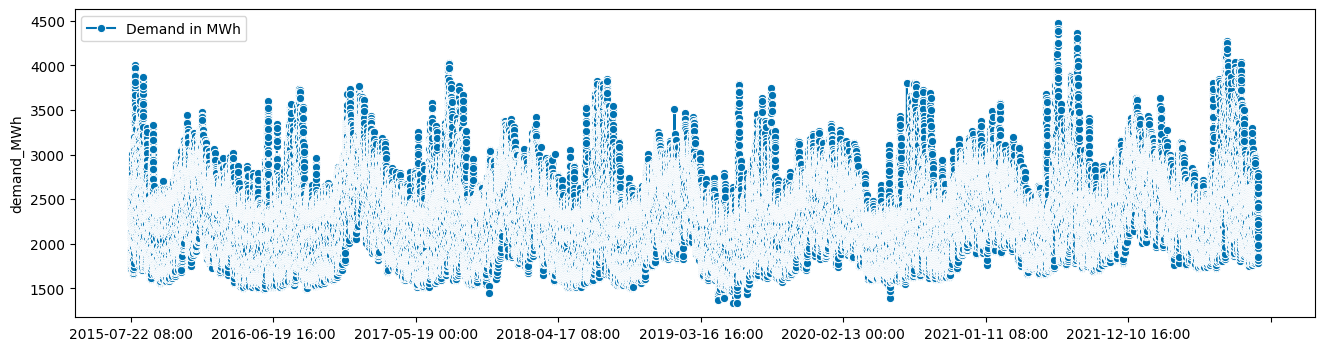

In [21]:
plot_series(y, labels=['Demand in MWh']);

### 2. Iterative Forecasting

Week-Ahead: Iterate fitting through 12-week training periods (overlapping in 11 weeks) to make week-ahead forecasts for 13th through 376th week of demand series

Day-Ahead: Iterate fitting through 12-week training periods (overlapping in 12 weeks minus one day) to make day-ahead forecasts for 85th through 2637th day of demand series


- Holt-Winters:
    - Redundant with better-scoring ARIMA fitting, but much faster and therefore done first
    - Scores well for how fast and simple it is
- ARIMA(1,0,0)(1,0,0)[24] => SAR:
    - Simple and intuitive model
    - Best day-ahead forecasting performance by MAE
- ARIMA(0,1,5)(0,0,2)[24] => SIMA:
    - Recommended by Auto ARIMA trained on a year of data
    - 4-week forecasting test (not any longer because poor performance)
- ARIMA(2,1,2)(1,0,1)[24] (no intercept) => SARIMA:
    - Recommended by Auto ARIMA trained on 12 weeks of data
    - Best week-ahead forecasting performance by MAE

In [25]:
# number of full weeks in series
63298 // 168

376

In [28]:
# 376 full weeks less first 12 for training: number of weeks to predict in week forecasts
376 - 12

364

In [26]:
# number of full days in series
63298 // 24

2637

In [30]:
# 2637 full days less first 12 weeks for training: number of days to predict in day forecasts
2637 - 7*12

2553

In [32]:
# number of hours in 1 week
24*7

168

In [33]:
# number of hours in 12 weeks
168*12

2016

#### 2a) Holt-Winters

**Week-Ahead:**

In [34]:
# HW forecasts for weeks 13 through 376
iter_hwpreds_week = []

for n in range(364):
    y_12weektrain = y[168*n: 2016 + 168*n]
    forecast_length = 168
    
    iter_hw_week = ExponentialSmoothing(y_12weektrain, seasonal_periods=24, trend=None, seasonal='add').fit()
    iter_hwpreds_week.append(iter_hw_week.forecast(forecast_length))

In [35]:
# convert to pandas series
iter_hwpreds_week_flat = pd.Series([pred for l in iter_hwpreds_week for pred in l], index=y.index[2016: 2016 + 168*364])

In [36]:
# score on MAE
mean_absolute_error(y[2016: 2016 + 168*364], iter_hwpreds_week_flat)

189.62382140963652

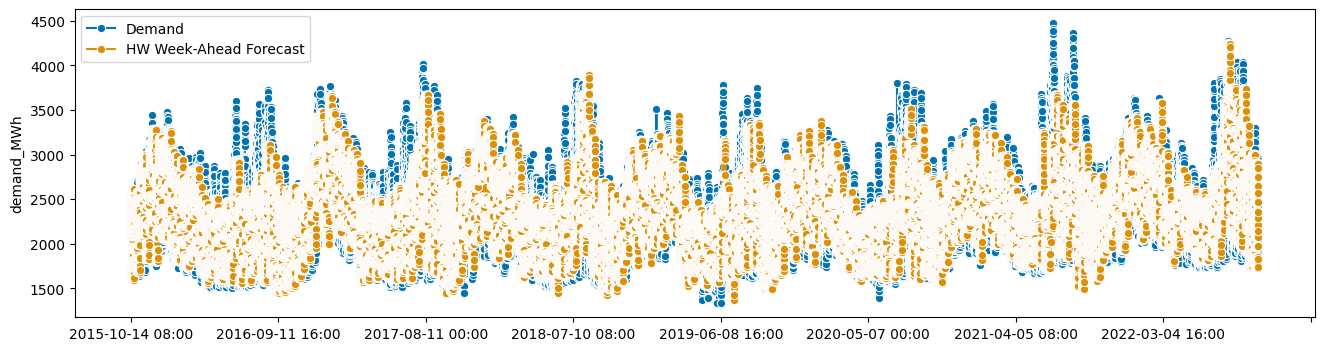

In [37]:
plot_series(y[2016: 2016 + 168*364], iter_hwpreds_week_flat, labels=['Demand', 'HW Week-Ahead Forecast']);

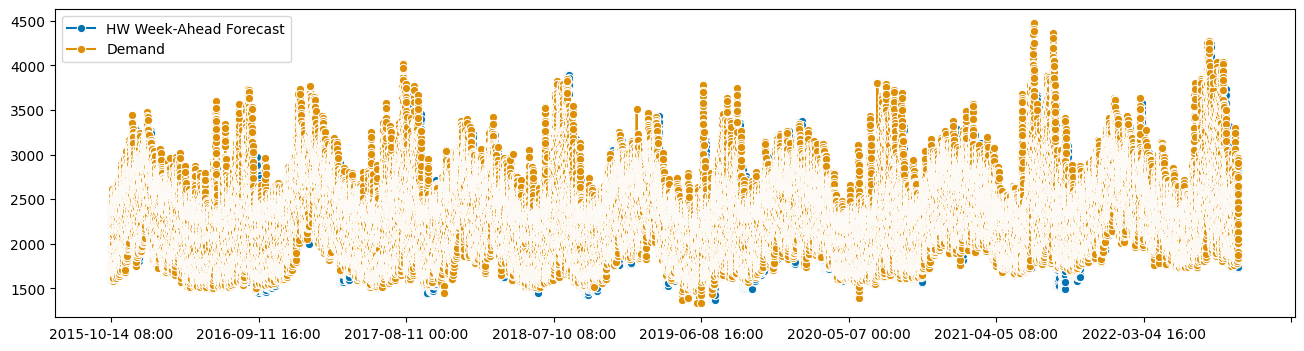

In [42]:
plot_series(iter_hwpreds_week_flat, y[2016: 2016 + 168*364], labels=['HW Week-Ahead Forecast', 'Demand']);

The week-ahead HW forecasts tend to be less extreme than the actual demand values high and low, though HW does a better job of predicting the smoother lows than the abrupt highs.

**Day-Ahead:**

In [38]:
# HW forecasts for days 85 through 2637
iter_hwpreds_day = []

for n in range(2553):
    y_12weektrain = y[24*n: 2016 + 24*n]
    forecast_length = 24
    
    iter_hw_day = ExponentialSmoothing(y_12weektrain, seasonal_periods=24, trend=None, seasonal='add').fit()
    iter_hwpreds_day.append(iter_hw_day.forecast(forecast_length))

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [39]:
# convert to pandas series
iter_hwpreds_day_flat = pd.Series([pred for l in iter_hwpreds_day for pred in l], index=y.index[2016: 2016 + 24*2553])

In [40]:
# score on MAE
mean_absolute_error(y[2016: 2016 + 24*2553], iter_hwpreds_day_flat)

142.0758922661536

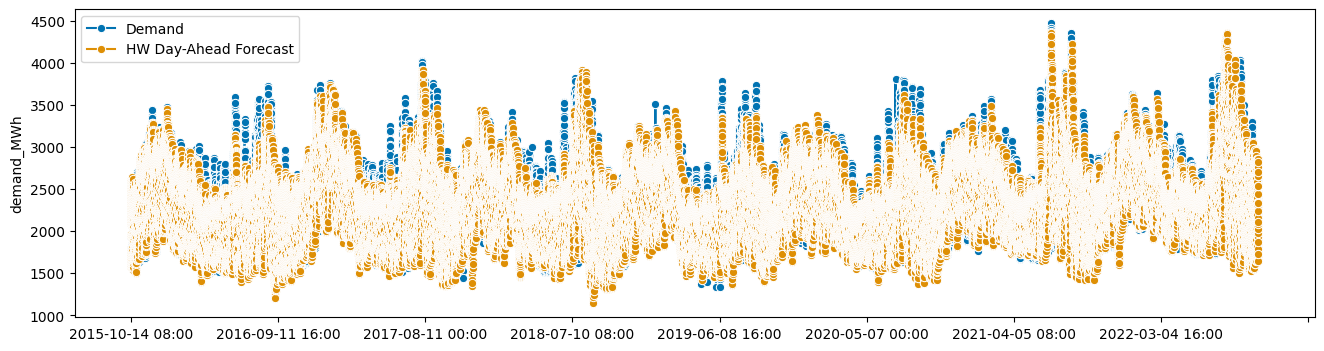

In [41]:
plot_series(y[2016: 2016 + 24*2553], iter_hwpreds_day_flat, labels=['Demand', 'HW Day-Ahead Forecast']);

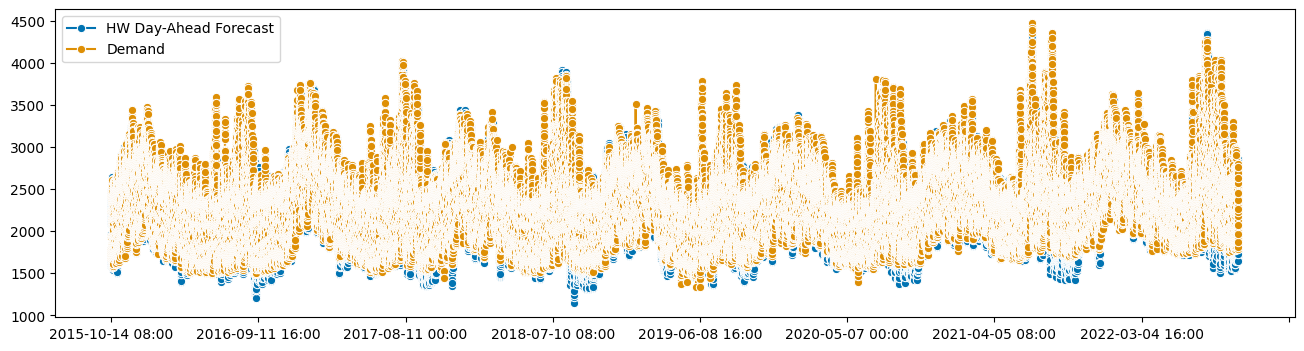

In [43]:
plot_series(iter_hwpreds_day_flat, y[2016: 2016 + 24*2553], labels=['HW Day-Ahead Forecast', 'Demand']);

The day-ahead HW forecasts do a better job than the week-ahead at predicting extreme demand swings, but overshoot on many of the lows. This seems to be the cost of better predicting the highs.

#### 2b) ARIMA(1,0,0)(1,0,0)[24] => SAR

**Week-Ahead:**

In [45]:
# SAR forecasts for weeks 13 through 376
iter_sarpreds_week = []

for n in range(364):
    y_12weektrain = y[168*n: 2016 + 168*n]
    
    iter_sar_week = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24), enforce_stationarity=False, suppress_warnings=True)
    iter_sar_week.fit(y_12weektrain)
    iter_sarpreds_week.append(iter_sar_week.predict(pd.RangeIndex(1, 169)))

In [46]:
# convert to pandas series
iter_sarpreds_week_flat = pd.Series([pred for l in iter_sarpreds_week for pred in l], index=y.index[2016: 2016 + 168*364])

In [47]:
# score on MAE
mean_absolute_error(y[2016: 2016 + 168*364], iter_sarpreds_week_flat)

203.37147340935533

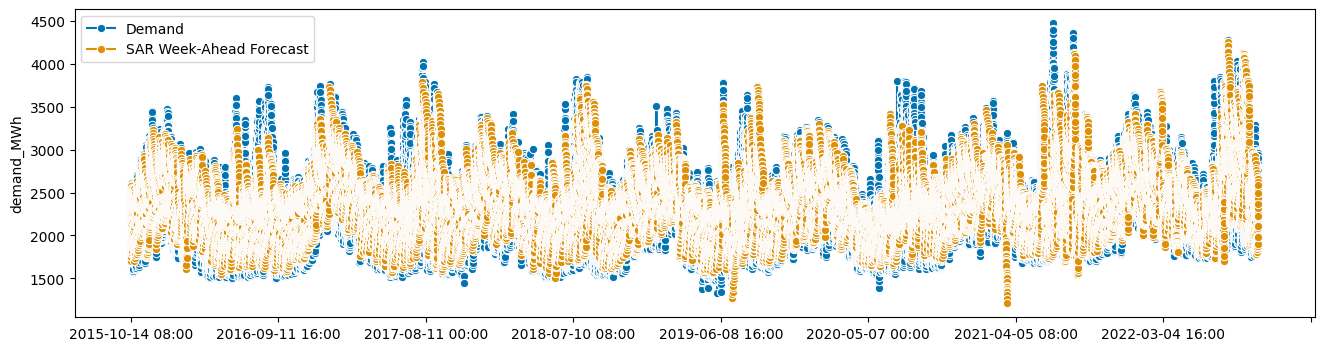

In [48]:
plot_series(y[2016: 2016 + 168*364], iter_sarpreds_week_flat, labels=['Demand', 'SAR Week-Ahead Forecast']);

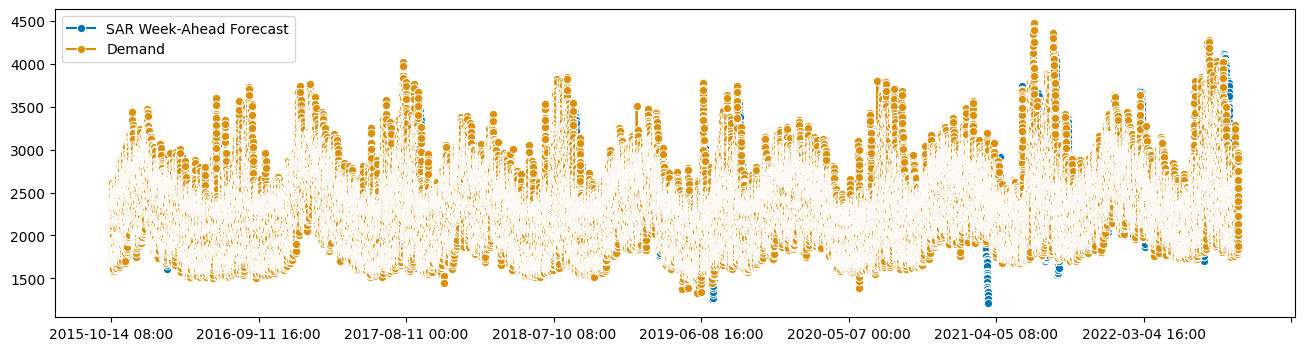

In [49]:
plot_series(iter_sarpreds_week_flat, y[2016: 2016 + 168*364], labels=['SAR Week-Ahead Forecast', 'Demand']);

In [ ]:
iter_sarpreds_week_flat.idxmin()

Period('2021-03-17 07:00', 'H')

In [60]:
iter_sarpreds_week_flat.loc[pd.Period('2021-03-15 00:00', 'H'): pd.Period('2021-03-17 10:00', 'H')]

2021-03-15 00:00    1585.791402
2021-03-15 01:00    1601.791730
2021-03-15 02:00    1658.144056
2021-03-15 03:00    1702.074578
2021-03-15 04:00    1688.022935
2021-03-15 05:00    1641.423825
2021-03-15 06:00    1578.600328
2021-03-15 07:00    1498.031888
2021-03-15 08:00    1439.107474
2021-03-15 09:00    1396.583615
2021-03-15 10:00    1370.457706
2021-03-15 11:00    1355.096831
2021-03-15 12:00    1356.754439
2021-03-15 13:00    1375.740868
2021-03-15 14:00    1436.139129
2021-03-15 15:00    1518.240604
2021-03-15 16:00    1567.928972
2021-03-15 17:00    1567.372489
2021-03-15 18:00    1537.213574
2021-03-15 19:00    1504.350642
2021-03-15 20:00    1486.611015
2021-03-15 21:00    1467.727111
2021-03-15 22:00    1449.573651
2021-03-15 23:00    1433.087007
2021-03-16 00:00    1418.577992
2021-03-16 01:00    1431.381273
2021-03-16 02:00    1477.438097
2021-03-16 03:00    1513.267715
2021-03-16 04:00    1501.332566
2021-03-16 05:00    1462.588296
2021-03-16 06:00    1410.483441
2021-03-

The SAR week-ahead forecasting performs similarly to HW, doing better in capturing gradual troughs than sudden spikes in demand. It makes some surprisingly low predictions on 3/16/21 and 3/17/21 (apparent on graph). It appears somewhat more balanced in predicting high and low swings than HW week-ahead, which seemed to do better on low than high.

**Day-Ahead:**

In [64]:
# SAR forecasts for days 85 through 2637
iter_sarpreds_day = []

for n in range(2553):
    y_12weektrain = y[24*n: 2016 + 24*n]
    
    iter_sar_day = ARIMA(order=(1,0,0), seasonal_order=(1,0,0,24), enforce_stationarity=False, suppress_warnings=True)
    iter_sar_day.fit(y_12weektrain)
    iter_sarpreds_day.append(iter_sar_day.predict(pd.RangeIndex(1, 25)))

In [65]:
# convert to pandas series
iter_sarpreds_day_flat = pd.Series([pred for l in iter_sarpreds_day for pred in l], index=y.index[2016: 2016 + 24*2553])

In [68]:
mean_absolute_error(y[2016: 2016 + 24*2553], iter_sarpreds_day_flat)

116.82594328933693

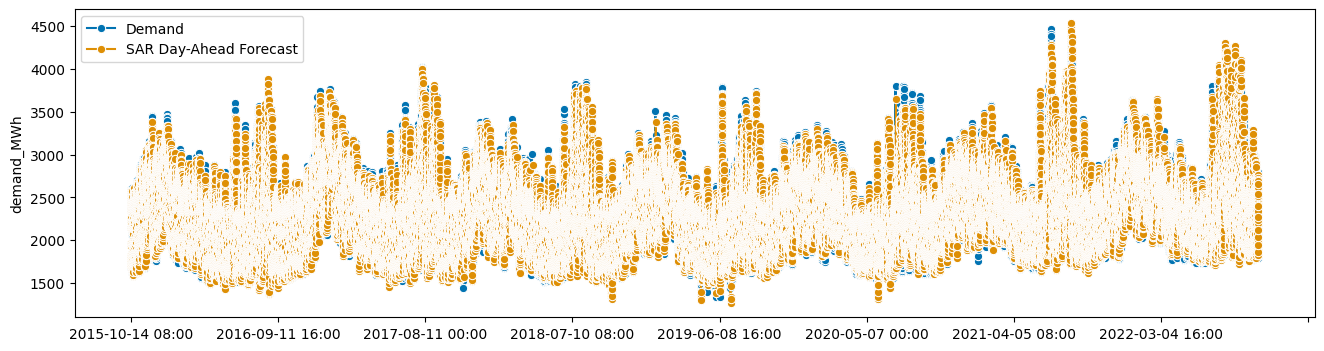

In [69]:
plot_series(y[2016: 2016 + 24*2553], iter_sarpreds_day_flat, labels=['Demand', 'SAR Day-Ahead Forecast']);

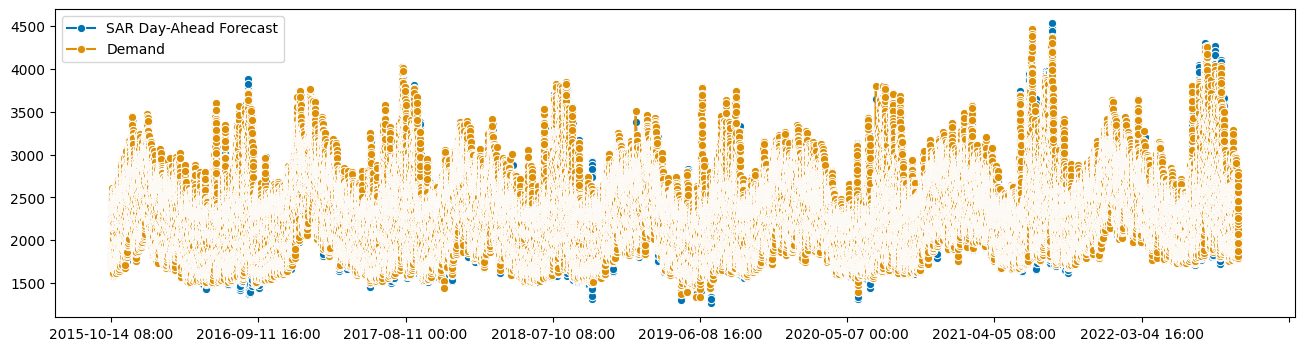

In [71]:
plot_series(iter_sarpreds_day_flat, y[2016: 2016 + 24*2553], labels=['SAR Day-Ahead Forecast', 'Demand']);

SAR day-ahead is visually and by MAE the best-performing model.

#### 2c) ARIMA(0,1,5)(0,0,2)[24] => SIMA

In [5]:
# SIMA forecasts for weeks 13 through 16: no intercept
iter_simapreds_week = []

for n in range(4):
    y_12weektrain = y[168*n: 2016 + 168*n]
    
    iter_sima_week = ARIMA(order=(0,1,5), seasonal_order=(0,0,2,24), enforce_stationarity=False, with_intercept=False)
    iter_sima_week.fit(y_12weektrain)
    iter_simapreds_week.append(iter_sima_week.predict(pd.RangeIndex(1, 169)))
    print(n)

0
1
2
3


In [ ]:
# convert to pandas series
iter_simapreds_week_flat = pd.Series([pred for l in iter_simapreds_week for pred in l], index=y.index[2016: 2016 + 168*4])

In [ ]:
mean_absolute_error(y[2016: 2016 + 168*4], iter_simapreds_week_flat)

459.9199259942219

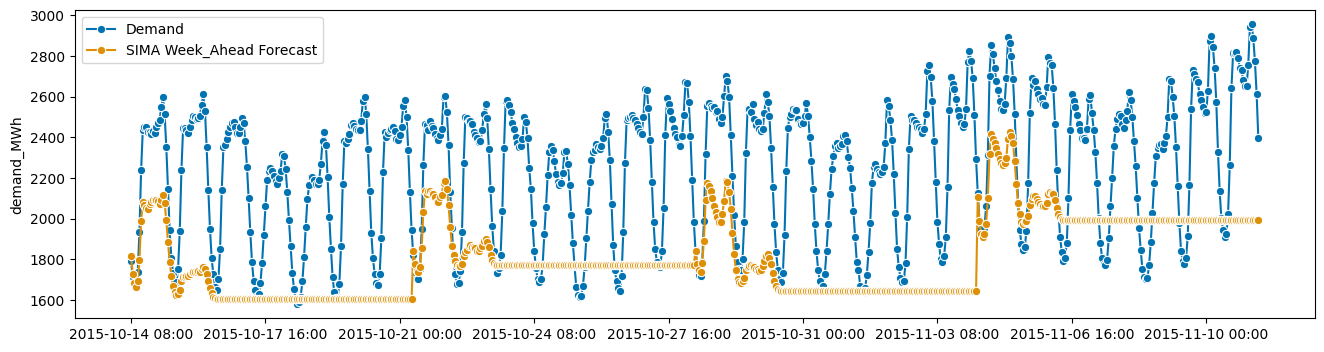

In [8]:
plot_series(y[2016: 2016 + 168*4], iter_simapreds_week_flat, labels=['Demand', 'SIMA Week_Ahead Forecast']);

In [9]:
# SIMA forecasts for weeks 13 through 16: with intercept
iter_simapreds_week = []

for n in range(4):
    y_12weektrain = y[168*n: 2016 + 168*n]
    
    iter_sima_week = ARIMA(order=(0,1,5), seasonal_order=(0,0,2,24), enforce_stationarity=False)
    iter_sima_week.fit(y_12weektrain)
    iter_simapreds_week.append(iter_sima_week.predict(pd.RangeIndex(1, 169)))
    print(n)

0
1
2
3


In [11]:
# convert to pandas series
iter_simapreds_week_flat = pd.Series([pred for l in iter_simapreds_week for pred in l], index=y.index[2016: 2016 + 168*4])

In [13]:
mean_absolute_error(y[2016: 2016 + 168*4], iter_simapreds_week_flat)

473.1893210831605

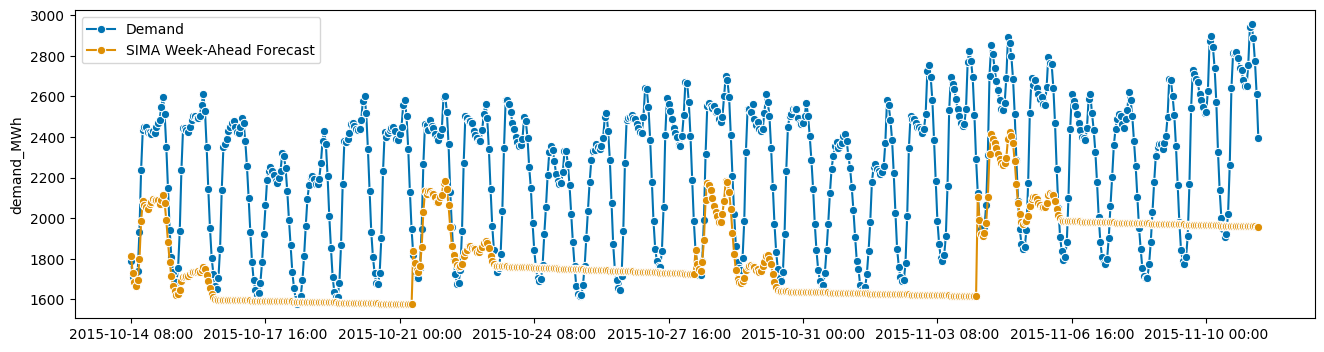

In [12]:
plot_series(y[2016: 2016 + 168*4], iter_simapreds_week_flat, labels=['Demand', 'SIMA Week-Ahead Forecast']);

This ARIMA specification, either with or without an intercept, is clearly not appropriate for fitting on 12 weeks of data.

#### 2d) ARIMA(2,1,2)(1,0,1)[24] (no intercept) => SARIMA

**Week-Ahead:**

In [12]:
# SARIMA forecasts for weeks 13 through 376
iter_sarimapreds_week = []

for n in range(364):
    y_12weektrain = y[168*n: 2016 + 168*n]
    
    iter_sarima_week = ARIMA(order=(2,1,2), seasonal_order=(1,0,1,24), enforce_stationarity=False, with_intercept=False, suppress_warnings=True)
    iter_sarima_week.fit(y_12weektrain)
    iter_sarimapreds_week.append(iter_sarima_week.predict(pd.RangeIndex(1, 169)))
    if n % 20 == 0:
        print(n)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360


In [13]:
# convert to pandas series
iter_sarimapreds_week_flat = pd.Series([pred for l in iter_sarimapreds_week for pred in l], index=y.index[2016: 2016 + 168*364])

In [14]:
mean_absolute_error(y[2016: 2016 + 168*364], iter_sarimapreds_week_flat)

178.77750387981823

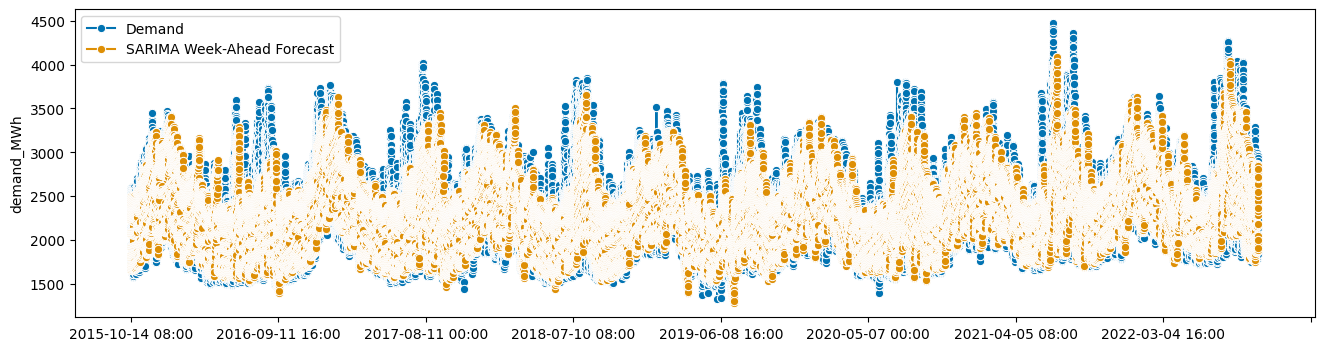

In [22]:
plot_series(y[2016: 2016 + 168*364], iter_sarimapreds_week_flat, labels=['Demand', 'SARIMA Week-Ahead Forecast']);

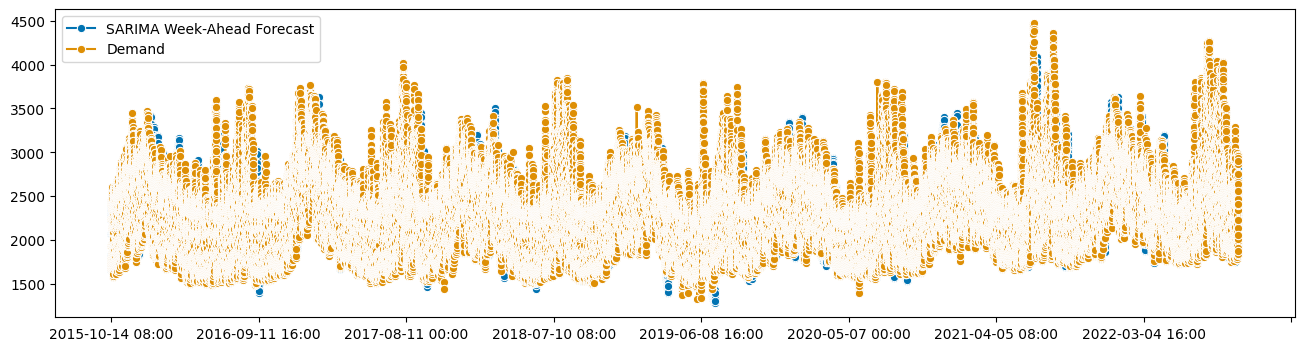

In [24]:
plot_series(iter_sarimapreds_week_flat, y[2016: 2016 + 168*364], labels=['SARIMA Week-Ahead Forecast', 'Demand']);

**Day-Ahead:**

In [5]:
# SARIMA forecasts for days 85 through 2637
iter_sarimapreds_day = []

for n in range(2553):
    y_12weektrain = y[24*n: 2016 + 24*n]
    
    iter_sarima_day = ARIMA(order=(2,1,2), seasonal_order=(1,0,1,24), enforce_stationarity=False, with_intercept=False, suppress_warnings=True)
    iter_sarima_day.fit(y_12weektrain)
    iter_sarimapreds_day.append(iter_sarima_day.predict(pd.RangeIndex(1, 25)))
    
    if n % 50 == 0:
        print(n)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550


In [6]:
# convert to pandas series
iter_sarimapreds_day_flat = pd.Series([pred for l in iter_sarimapreds_day for pred in l], index=y.index[2016: 2016 + 24*2553])

In [7]:
mean_absolute_error(y[2016: 2016 + 24*2553], iter_sarimapreds_day_flat)

134.68756696065086

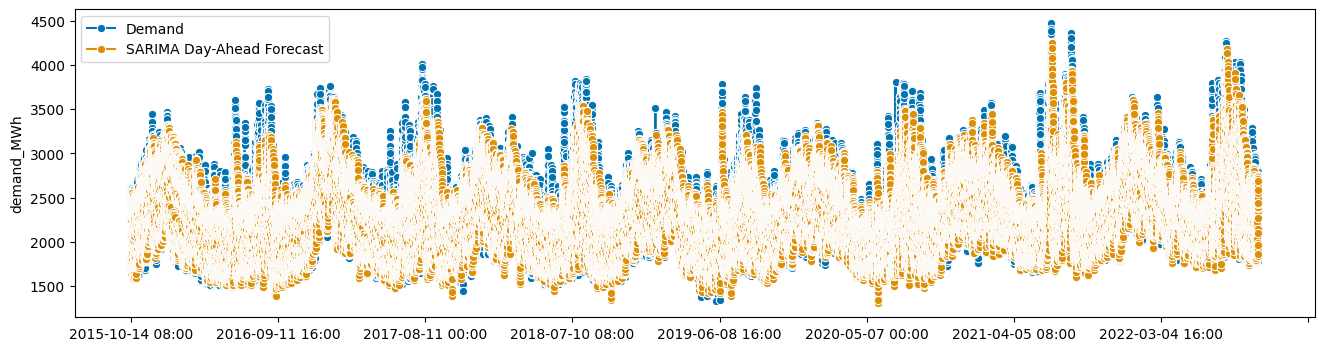

In [8]:
plot_series(y[2016: 2016 + 24*2553], iter_sarimapreds_day_flat, labels=['Demand', 'SARIMA Day-Ahead Forecast']);

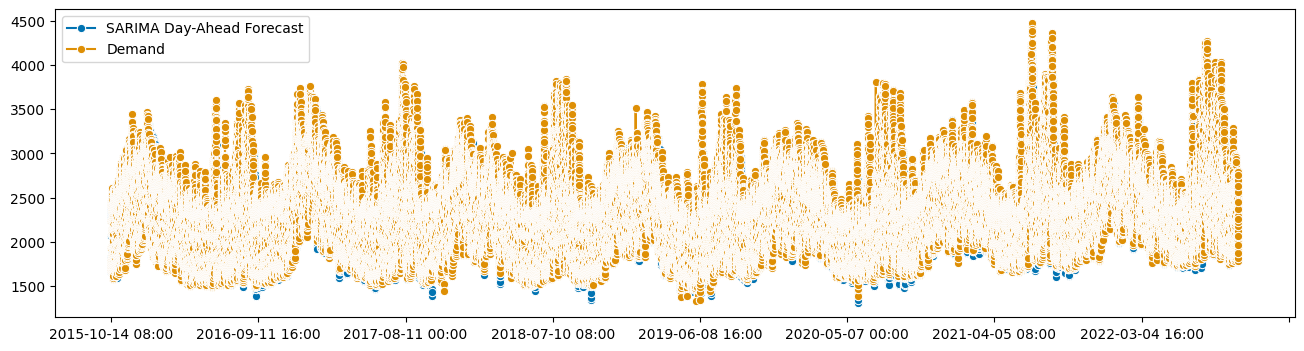

In [9]:
plot_series(iter_sarimapreds_day_flat, y[2016: 2016 + 24*2553], labels=['SARIMA Day-Ahead Forecast', 'Demand']);

The SARIMA day-ahead forecasts are better than its week-ahead forecasts, but surprisingly worse than the SAR day-ahead forecasts. This must have something to do with AIC, by which Auto-ARIMA determined this SARIMA to be the best specification for a 12-week training period. That is, there is a discrepancy between judging a model using AIC and judging a model using MAE.

### 3. Save Full Predictions

In [62]:
iter_hwpreds_week_flat.to_csv('../data/forecasts/full_hw_weekpreds.csv')

In [62]:
iter_hwpreds_day_flat.to_csv('../data/forecasts/full_hw_daypreds.csv')

In [62]:
iter_sarpreds_week_flat.to_csv('../data/forecasts/full_sar1_weekpreds.csv')

In [62]:
iter_sarpreds_day_flat.to_csv('../data/forecasts/full_sar1_daypreds.csv')

In [15]:
iter_sarimapreds_week_flat.to_csv('../data/forecasts/full_sarima_weekpreds.csv')

In [ ]:
iter_sarimapreds_day_flat.to_csv('../data/forecasts/full_sarima_daypreds.csv')